In [2]:
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD,Adadelta,Adam,RMSprop 
from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.utils import np_utils
import itertools
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Dropout

# load data

In [44]:
file_name = 'train_data.csv'               #train set
train_df = pd.read_csv(file_name,parse_dates=['DateID'])
print(train_df.shape)
train_df.head()


(19921, 4)


,CategoryCode,ItemCode,DateID,DailySales
0,category_2,117610,2021-11-06,7
1,category_4,836584,2021-11-18,16
2,category_1,370195,2022-01-24,6
3,category_2,172582,2021-10-30,5
4,category_2,1006009,2021-10-30,5


In [5]:
validation_df = pd.read_csv('validation_data.csv')       #validation set
print(validation_df.shape)
validation_df.head()

(370, 4)


,CategoryCode,ItemCode,Week,WeeklySales
0,category_2,1044502,w1,11
1,category_2,1105009,w1,11
2,category_2,913561,w4,5
3,category_1,1048975,w4,30
4,category_1,17287,w2,60


In [106]:
test_df = pd.read_csv('test_data.csv')       #validation set
print(test_df.shape)
test_df.head()

(377, 4)


,CategoryCode,ItemCode,Week,WeeklySales
0,category_1,43738,w4,16
1,category_2,1006090,w1,11
2,category_2,1076929,w4,4
3,category_1,1081321,w3,10
4,category_2,216151,w4,15


# distribution of daily sales during the period 1st October 2021 to 13th February 2022

In [86]:
dailysales_df = train_df.groupby('DateID').DailySales.count()
dailysales_df

DateID
2021-10-01    143
2021-10-02    158
2021-10-03    154
2021-10-04    140
2021-10-05    129
             ... 
2022-02-09    125
2022-02-10    148
2022-02-11    145
2022-02-12    150
2022-02-13    141
Name: DailySales, Length: 136, dtype: int64

In [87]:
dailysales_df = dailysales_df.to_frame()
dailysales_df

,DailySales
DateID,
2021-10-01,143
2021-10-02,158
2021-10-03,154
2021-10-04,140
2021-10-05,129
...,...
2022-02-09,125
2022-02-10,148
2022-02-11,145


In [94]:
dailySales_data = [go.Scatter( x=dailysales_df.index,y=dailysales_df.DailySales)]
py.iplot(dailySales_data)

In [95]:
dailysales_df['DailySales_bins']=pd.cut(dailysales_df['DailySales'],[100,110,120,130,140,150,160,170])
print('Max sale:', dailysales_df.DailySales.max())
print('Min sale:', dailysales_df.DailySales.min())
print('Avg sale:', dailysales_df.DailySales.mean())
dailysales_df

Max sale: 168
Min sale: 125
Avg sale: 146.47794117647058


,DailySales,DailySales_bins
DateID,,
2021-10-01,143,"(140, 150]"
2021-10-02,158,"(150, 160]"
2021-10-03,154,"(150, 160]"
2021-10-04,140,"(130, 140]"
2021-10-05,129,"(120, 130]"
...,...,...
2022-02-09,125,"(120, 130]"
2022-02-10,148,"(140, 150]"
2022-02-11,145,"(140, 150]"


In [96]:
total_points = pd.value_counts(dailysales_df.DailySales_bins).sum()
print('Sales bucket v/s Total percentage:')
pd.value_counts(dailysales_df.DailySales_bins).apply(lambda s: (s/total_points)*100)

Sales bucket v/s Total percentage:


(140, 150]    48.529412
(150, 160]    26.470588
(130, 140]    16.176471
(120, 130]     4.411765
(160, 170]     4.411765
(100, 110]     0.000000
(110, 120]     0.000000
Name: DailySales_bins, dtype: float64

<AxesSubplot:title={'center':'Sales distribution'}>

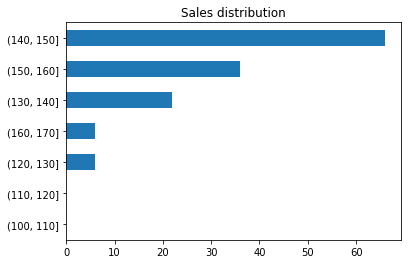

In [97]:
sales_count = pd.value_counts(dailysales_df.DailySales_bins)
sales_count.sort_values(ascending=True).plot(kind='barh', title='Sales distribution', )

Max,min and avg Daily sales are 168,125 and 146.478.

# Sales distribution among categories

In [100]:
sales_pivoted_df = pd.pivot_table(train_df, index='CategoryCode', values=['DailySales','DateID'], columns='ItemCode', aggfunc=np.mean)
sales_across_store_df = sales_pivoted_df.copy()
sales_across_store_df['AvgDailySale'] = sales_across_store_df.apply(lambda r: r.mean(), axis=1)
sales_across_store_df['AvgDailySale']


CategoryCode
category_1     6.280729
category_2     4.139096
category_3    10.856383
category_4    15.820818
Name: AvgDailySale, dtype: float64

In [101]:
# Scatter plot of average sales per store
sales_store_data = go.Scatter(
    y = sales_across_store_df.AvgDailySale.values,
    mode='markers',
    marker=dict(
        size = sales_across_store_df.AvgDailySale.values,
        color = sales_across_store_df.AvgDailySale.values,
        colorscale='Viridis',
        showscale=True
    ),
    text = sales_across_store_df.index.values
)
data = [sales_store_data]

sales_store_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg Daily sales per Category',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Category',
        ticklen= 4,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Daily Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_store_layout)
py.iplot(fig,filename='scatter_sales_store')

From the visualization, It is clear that the daily average sales descend in the order category_4, category_3, category_1 and category_2.

In [104]:
sales_pivoted_df

DailySales                                                    \
ItemCode        3418      3427      7666      9925      16936     17287     
CategoryCode                                                                
category_1     9.829457  6.538462       NaN       NaN       NaN  4.293478   
category_2          NaN       NaN       NaN  2.479167       NaN       NaN   
category_3          NaN       NaN  14.80531       NaN  8.135135       NaN   
category_4          NaN       NaN       NaN       NaN       NaN       NaN   

                                                         ...            \
ItemCode        17296      20824      23200     23569    ...   1098502   
CategoryCode                                             ...             
category_1    71.191176        NaN        NaN       NaN  ...       NaN   
category_2          NaN  18.647059        NaN  3.530973  ...  1.594937   
category_3          NaN        NaN        NaN       NaN  ...       NaN   
category_4          NaN        NaN  13.860759       NaN  ...       NaN   

                                                                        \
ItemCode       1101553   1101562 1101571   1101661   1101769   1103056   
CategoryCode                                                             
category_1         NaN       NaN     NaN       NaN       NaN       NaN   
category_2    1.906667  2.265957     4.8       NaN  2.921053  2.826923   
category_3         NaN       NaN     NaN  6.205607       NaN       NaN   
category_4         NaN       NaN     NaN       NaN       NaN       NaN   

                                            
ItemCode       1105009   1105018   1105027  
CategoryCode                                
category_1         NaN       NaN       NaN  
category_2    1.898551  1.863636  1.961538  
category_3         NaN       NaN       NaN  
category_4         NaN       NaN       NaN  

[4 rows x 194 columns]

# Sales distribution among items

In [102]:
sales_across_item_df = sales_pivoted_df.copy()
# Aggregate the sales per item and add it as a new row in the same dataframe
sales_across_item_df.loc[11] = sales_across_item_df.apply(lambda r: r.mean(), axis=0)
# Note the 11th index row, which is the average sale of each of the item across all the stores
#display(sales_across_item_df.loc[11:])
array_1 = sales_across_item_df.columns.get_level_values(1).to_numpy()
array_2 = sales_across_item_df.loc[11:].values[0]
list_3 = []
for i in range(len(array_1)):
    k= array_1[i],array_2[i]
    list_3.append(k)
avg_sales_per_item_across_stores_df = pd.DataFrame(data=[[i,a] for i,a in list_3], columns=['ItemID', 'AvgDailySale'])
# And finally, sort by avg sale
avg_sales_per_item_across_stores_df.sort_values(by='AvgDailySale', ascending=False, inplace=True)
# Display the top 10 rows
avg_sales_per_item_across_stores_df.head(5)

,ItemID,AvgDailySale
60,169504,89.355556
49,123307,71.310606
6,17296,71.191176
157,1074823,34.094118
48,119554,22.742647


In [103]:
avg_sales_per_item_across_stores_df

,ItemID,AvgDailySale
60,169504,89.355556
49,123307,71.310606
6,17296,71.191176
157,1074823,34.094118
48,119554,22.742647
...,...,...
184,1098502,1.594937
151,1068883,1.532258
173,1090105,1.520548
119,1030948,1.473684


In [164]:
avg_sales_per_item_across_stores_df.tail(5)

,ItemID,AvgDailySale
184,1098502,1.594937
151,1068883,1.532258
173,1090105,1.520548
119,1030948,1.473684
33,64978,1.421875


In [165]:
avg_sales_per_item_across_stores_sorted = avg_sales_per_item_across_stores_df.AvgDailySale.values
# Scatter plot of average sales per item
sales_item_data = go.Bar(
    x=[i for i in range(0, 200)],
    y=avg_sales_per_item_across_stores_sorted,
    marker=dict(
        color=avg_sales_per_item_across_stores_sorted,
        colorscale='Blackbody',
        showscale=True
    ),
    text = avg_sales_per_item_across_stores_df.ItemID.values
)
data = [sales_item_data]

sales_item_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per item',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Items',
        ticklen= 200,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_item_layout)
py.iplot(fig,filename='scatter_sales_item')

Top items with highest average sales are 169504, 123307, 17296 (ItemCode).
Items with the least average sales are 64978, 1030948, 1090105, 1068883 (ItemCode).

# Time-series visualization of Sales

In [177]:
store_item_df = train_df.copy()
item_id = 	169504
store_item_df = store_item_df[store_item_df.ItemCode == item_id]
store_item_df = store_item_df.sort_values(by='DateID')

store_item_ts_data = [go.Scatter( x=store_item_df.DateID,y=store_item_df.DailySales)]
py.iplot(store_item_ts_data)
    

In [176]:
store_item_df = train_df.copy()
item_id = 64978	
store_item_df = store_item_df[store_item_df.ItemCode == item_id]
store_item_df = store_item_df.sort_values(by='DateID')

store_item_ts_data = [go.Scatter( x=store_item_df.DateID,y=store_item_df.DailySales)]
py.iplot(store_item_ts_data)
    

In [180]:
train_df

,CategoryCode,ItemCode,DateID,DailySales
0,category_2,117610,2021-11-06,7
1,category_4,836584,2021-11-18,16
2,category_1,370195,2022-01-24,6
3,category_2,172582,2021-10-30,5
4,category_2,1006009,2021-10-30,5
...,...,...,...,...
19916,category_2,225259,2021-10-04,4
19917,category_2,111436,2021-10-12,1
19918,category_2,1098502,2021-10-01,1
19919,category_2,20824,2021-10-01,7


In [215]:
multi_store_item_df = train_df.copy()
# First, let us filterout the required data
#category_ids = ['category_1', 'category_2', 'category_3', 'category_4']   # Some stores
item_ids = [169504, 123307,17296, 1098502, 64978,1030948, 1068883]    # Some items
print('Before filter:', multi_store_item_df.shape)
#multi_store_item_df = multi_store_item_df[multi_store_item_df.CategoryCode.isin(category_ids)]
multi_store_item_df = multi_store_item_df[multi_store_item_df.ItemCode.isin(item_ids)]
print('After filter:', multi_store_item_df.shape)
#display(multi_store_item_df)
# TODO Monthly avg sales
multi_store_item_df= multi_store_item_df.sort_values(by="DateID")
# Let us plot this now

multi_store_item_ts_data = []
for it in  item_ids:
    #flt = multi_store_item_df[multi_store_item_df.CategoryCode == st]
    flt = multi_store_item_df[multi_store_item_df.ItemCode == it]
    multi_store_item_ts_data.append(go.Scatter(x=flt.DateID, y=flt.DailySales, name =  "Item:" + str(it)))
py.iplot(multi_store_item_ts_data)
    

Before filter: (19921, 4)
After filter: (684, 4)


In [216]:
import matplotlib.ticker as ticker
import seaborn as sns

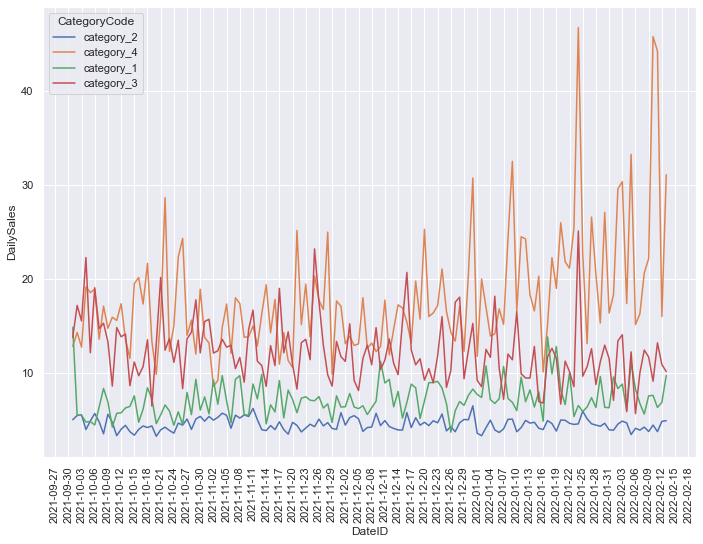

In [217]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.lineplot(x='DateID', y='DailySales', hue='CategoryCode', data=train_df, ci=None) 

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=3))

plt.show()

In [24]:
#number of categories and items
train_df.CategoryCode.nunique(),train_df.ItemCode.nunique(),validation_df.CategoryCode.nunique(),validation_df.ItemCode.nunique(),test_df.CategoryCode.nunique(),test_df.ItemCode.nunique()

(4, 194, 4, 95, 4, 97)

In [27]:
#time range
train_df['DateID'].min(),train_df['DateID'].max()

(Timestamp('2021-10-01 00:00:00'), Timestamp('2022-02-13 00:00:00'))

In [29]:
#number of items per category
train_df.groupby(['CategoryCode'])['ItemCode'].nunique()

CategoryCode
category_1    67
category_2    90
category_3    22
category_4    15
Name: ItemCode, dtype: int64

In [30]:
#stats of each item

train_df.groupby(["ItemCode"]).agg({"DailySales": ["count","sum", "mean", "median", "std", "min", "max"]})

DailySales                                            
              count   sum       mean median        std min  max
ItemCode                                                       
3418            129  1268   9.829457    9.0   6.414247   1   29
3427            130   850   6.538462    5.0   5.760267   1   44
7666            113  1673  14.805310   11.0  14.660356   1   79
9925             96   238   2.479167    2.0   2.082403   1   13
16936           111   903   8.135135    5.0  13.760607   1  140
...             ...   ...        ...    ...        ...  ..  ...
1101769          76   222   2.921053    2.0   2.267234   1   11
1103056         104   294   2.826923    2.0   1.803138   1   10
1105009          69   131   1.898551    1.0   1.164991   1    5
1105018          66   123   1.863636    1.0   1.188229   1    6
1105027          78   153   1.961538    1.5   1.178182   1    5

[194 rows x 7 columns]

Text(0.5, 0.98, 'Histogram: DailySales')

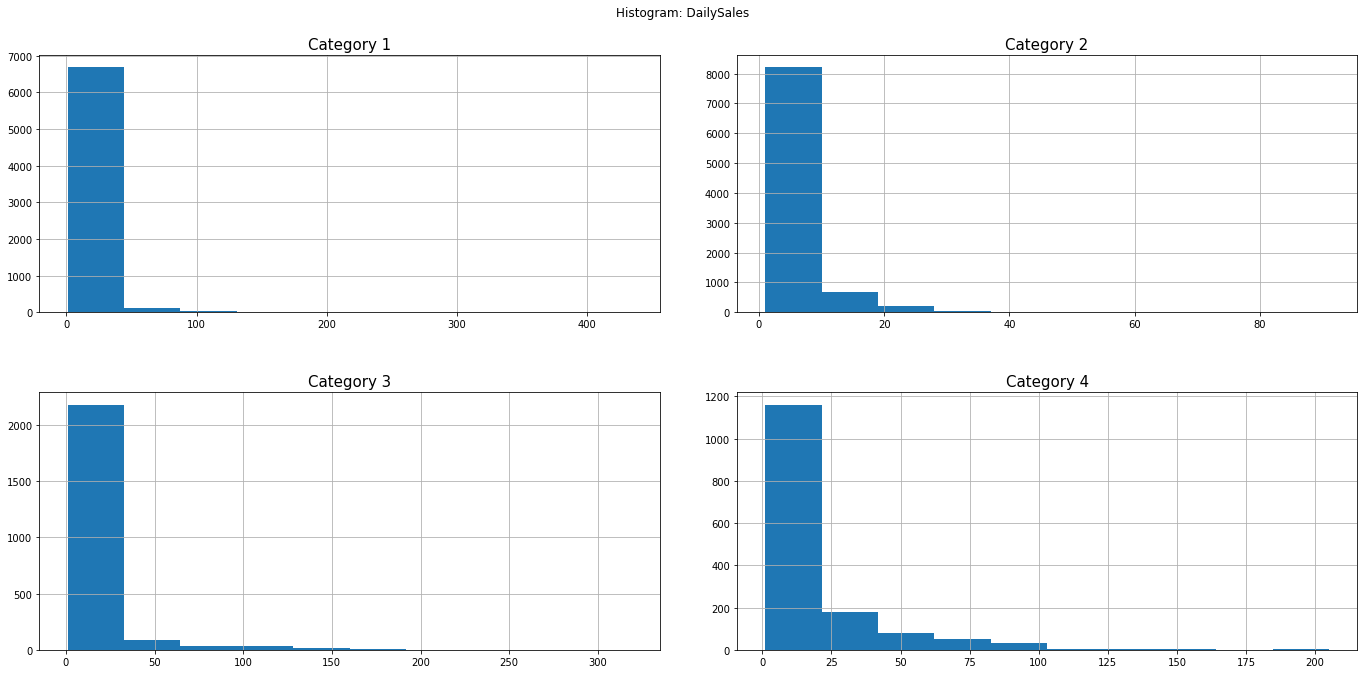

In [34]:
#category sales
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
for i in range(1,5):
    if i < 3:
        train_df[train_df.CategoryCode == 'category_'+str(i)].DailySales.hist(ax=axes[0, i-1])
        axes[0,i-1].set_title("Category " + str(i), fontsize = 15)
        
    else:
        train_df[train_df.CategoryCode == 'category_'+str(i)].DailySales.hist(ax=axes[1, i -3])
        axes[1,i-3].set_title("Category " + str(i), fontsize = 15)
plt.tight_layout(pad=4.5)
plt.suptitle("Histogram: DailySales")

# Test

In [110]:
test_df

,CategoryCode,ItemCode,Week,WeeklySales
0,category_1,43738,w4,16
1,category_2,1006090,w1,11
2,category_2,1076929,w4,4
3,category_1,1081321,w3,10
4,category_2,216151,w4,15
...,...,...,...,...
372,category_2,1101571,w1,4
373,category_2,1090258,w4,7
374,category_2,906595,w1,4
375,category_2,32245,w1,29


In [118]:
multi_store_item_df[multi_store_item_df.ItemCode==169504]

,CategoryCode,ItemCode,Week,WeeklySales
284,category_3,169504,w1,151
313,category_3,169504,w2,151
107,category_3,169504,w3,148
39,category_3,169504,w4,163


In [113]:
multi_store_item_df = test_df.copy()
# First, let us filterout the required data
#category_ids = ['category_1', 'category_2', 'category_3', 'category_4']   # Some stores
item_ids = [169504, 123307,17296, 1098502, 64978,1030948, 1068883]    # Some items
print('Before filter:', multi_store_item_df.shape)
#multi_store_item_df = multi_store_item_df[multi_store_item_df.CategoryCode.isin(category_ids)]
multi_store_item_df = multi_store_item_df[multi_store_item_df.ItemCode.isin(item_ids)]
print('After filter:', multi_store_item_df.shape)
#display(multi_store_item_df)
# TODO Monthly avg sales
multi_store_item_df= multi_store_item_df.sort_values(by="Week")
# Let us plot this now

multi_store_item_ts_data = []
for it in  item_ids:
    #flt = multi_store_item_df[multi_store_item_df.CategoryCode == st]
    flt = multi_store_item_df[multi_store_item_df.ItemCode == it]
    multi_store_item_ts_data.append(go.Scatter(x=flt.Week, y=flt.WeeklySales, name =  "Item:" + str(it)))
py.iplot(multi_store_item_ts_data)
    

Before filter: (377, 4)
After filter: (12, 4)


In [120]:
sales_pivoted_df = pd.pivot_table(test_df, index='CategoryCode', values=['WeeklySales','Week'], columns='ItemCode', aggfunc=np.mean)
sales_across_store_df = sales_pivoted_df.copy()
sales_across_store_df['AvgWeeklySale'] = sales_across_store_df.apply(lambda r: r.mean(), axis=1)
sales_across_store_df['AvgWeeklySale']

CategoryCode
category_1    23.610294
category_2    11.869048
category_3    41.416667
category_4    25.175926
Name: AvgWeeklySale, dtype: float64

In [122]:
sales_across_item_df = sales_pivoted_df.copy()
# Aggregate the sales per item and add it as a new row in the same dataframe
sales_across_item_df.loc[11] = sales_across_item_df.apply(lambda r: r.mean(), axis=0)
# Note the 11th index row, which is the average sale of each of the item across all the stores
#display(sales_across_item_df.loc[11:])
array_1 = sales_across_item_df.columns.get_level_values(1).to_numpy()
array_2 = sales_across_item_df.loc[11:].values[0]
list_3 = []
for i in range(len(array_1)):
    k= array_1[i],array_2[i]
    list_3.append(k)
avg_sales_per_item_across_stores_df = pd.DataFrame(data=[[i,a] for i,a in list_3], columns=['ItemID', 'AvgWeeklySale'])
# And finally, sort by avg sale
avg_sales_per_item_across_stores_df.sort_values(by='AvgWeeklySale', ascending=False, inplace=True)
# Display the top 10 rows
avg_sales_per_item_across_stores_df.head(5)

,ItemID,AvgWeeklySale
31,169504,153.25
26,123307,141.25
25,119554,109.00
8,37861,108.50
64,1047967,92.25


In [123]:
avg_sales_per_item_across_stores_df.tail(5)

,ItemID,AvgWeeklySale
61,1032568,3.25
74,1068883,3.00
84,1081339,2.75
78,1076929,2.75
90,1101553,2.00
